# NYC Yellow Taxi Tips Prediction

This example is based on the [NYC Yellow Cab trip record data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) made available by the NYC Taxi and Limousine Commission (TLC). This dataset has been widely used on Kaggle and elsewhere. Todd Schneider has written [a nice in-depth analysis of the dataset](https://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/).

After exploring the data, we will use a regression model to predict taxi tips.

## Import all packages

These are the main packages we are going to work with:

* [s3fs](https://s3fs.readthedocs.io/en/latest/#) to download data from AWS S3 buckets;
* [Pandas](https://pandas.pydata.org) to manipulate tabular data structures;
* [Seaborn](https://seaborn.pydata.org/index.html) and [Matplotlib](https://matplotlib.org) for data visualization; and
* [Scikit-Learn](https://scikit-learn.org/stable/) to build and evaluate regression models.

In [1]:
import sys
!{sys.executable} -m pip install numpy pandas pyarrow s3fs scikit-learn seaborn matplotlib -q

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

We use the data from the year 2019 . We can fetch the data directly from the [NYC Taxi & Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page); alternatively, we can get it from one of ...'s AWS S3 open buckets (no AWS credentials required).

In the following cell, we load the dataset directly from AWS using the URI `s3://.../yellow_tripdata_2019.csv`.

In [19]:
taxi = pd.read_parquet(
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet",
    # "s3://.../yellow_tripdata_2023-01.parquet",
)
print(taxi.head(1))
print(taxi.shape)

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-01-01 00:35:40   2022-01-01 00:53:29              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            3.8         1.0                  N           142           236   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         14.5    3.0      0.5        3.65           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    0.3         21.95                   2.5          0.0  
(2463931, 19) Index                         132
VendorID                 19711448
tpep_pickup_datetime     19711448
tpep_dropoff_datetime    19711448
passenger_count          19711448
trip_distance            19711448
RatecodeID               19711448
store_and_fwd_flag       19711448
PULocationID             19711448
DOLocationID             19711448
payment_type             19711448
f

In [25]:
mem_df = taxi.memory_usage(deep=True, index=True).sum() / 1e6
print(f"'taxi' DataFrame is of size: {mem_df} MB")

'taxi' DataFrame is of size: 495.283092 MB


## Exploratory analysis

The dataset consist of 18 columns; see the [TLS documentation](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) for more details on the meanings of each field. Our goal here is to predict the tip amount of a ride using some features.

Before doing anything, it might be interesting for us to look at the raw data to see if we can extract patterns.

In [4]:
# remove fare=0 and only keep credit card trips
taxi_filtered = taxi[
    (taxi.fare_amount > 0) & (taxi.payment_type == 1) & (taxi.trip_distance > 0.01)
].copy()

# the quantity of interest
taxi_filtered['tip_fraction'] = taxi_filtered.tip_amount / taxi_filtered.fare_amount

# tpep_pickup_datetime
taxi_filtered['pickup_weekday'] = taxi_filtered.tpep_pickup_datetime.dt.weekday
taxi_filtered['pickup_week'] = taxi_filtered.tpep_pickup_datetime.dt.isocalendar().week
taxi_filtered['pickup_hour'] = taxi_filtered.tpep_pickup_datetime.dt.hour
taxi_filtered['pickup_week_hour'] = (taxi_filtered.pickup_weekday * 24) + taxi_filtered.pickup_hour
taxi_filtered['pickup_minute'] = taxi_filtered.tpep_pickup_datetime.dt.minute

# tpep_dropoff_datetime
taxi_filtered['dropoff_weekday'] = taxi_filtered.tpep_dropoff_datetime.dt.weekday
taxi_filtered['dropoff_week'] = taxi_filtered.tpep_dropoff_datetime.dt.isocalendar().week
taxi_filtered['dropoff_hour'] = taxi_filtered.tpep_dropoff_datetime.dt.hour
taxi_filtered['dropoff_week_hour'] = (taxi_filtered.dropoff_weekday * 24) + taxi_filtered.dropoff_hour
taxi_filtered['dropoff_minute'] = taxi_filtered.tpep_dropoff_datetime.dt.minute

There are a few preprocessing steps we can make based on insights available from examining the dataset. The data sheet states "cash tips are not included," so we'll look at credit card transactions exclusively. Other fields are unclear and show rows have some suspicious entries (e.g., a trip of length 0 miles with no charge but a tip of 50 dollars). To mitigate the presence of outliers and data pollution, we modify the data beforehand by:

1. removing records with a price of 0 dollars;
2. removing records with a trip distance of < 0.01 miles;
3. keeping only records with credit card transactions;
4. computing `tip_fraction` only for these relevant records; and
5. processing the date into discrete values (day of the week, day of the month, etc.).

First, let's have a look at both `tip_fraction` and `fare_amount` distributions. The dataset is randomly subsampled to facilitate computations.

In [5]:
sample = taxi_filtered.sample(9_999)

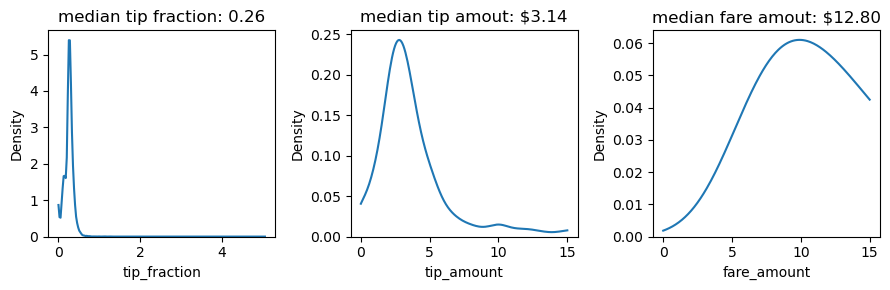

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
clip = [0, 15]

sns.kdeplot(data=sample, x="tip_fraction", ax=axs[0], clip=clip)
axs[0].set_title(f"median tip fraction: {sample['tip_fraction'].median():.2f}")

sns.kdeplot(data=sample, x="tip_amount", ax=axs[1], clip=clip)
axs[1].set_title(f"median tip amout: ${sample['tip_amount'].median():.2f}")

sns.kdeplot(data=sample, x="fare_amount", ax=axs[2], clip=clip)
axs[2].set_title(f"median fare amout: ${sample['fare_amount'].median():.2f}")

fig.tight_layout()

We can use the whole dataset to compute descriptive statistics.

In [7]:
print(taxi_filtered['tip_fraction'].describe())

count    2.390115e+06
mean     2.596714e-01
std      9.480091e+00
min      0.000000e+00
25%      2.000000e-01
50%      2.613497e-01
75%      3.075269e-01
max      1.450000e+04
Name: tip_fraction, dtype: float64


Even after filtering the data, there are still interesting things to note on the tip fraction. Apparently someone tipped 4500x the fare... 

We often use correlation matrices in machine learning to identify important features. And, in this case, we want to know which features can be used to predict tips.

In [16]:
corr = taxi_filtered.corr(numeric_only=True)

In [17]:
corr_tip_amount = pd.DataFrame(corr["tip_amount"])

# remove the tip_amount itself from the correlation since it's 1
# also total_amount is directly computed from the tip_amount
index = list(corr_tip_amount.index)
index.remove("tip_amount")
index.remove("total_amount")
index.remove("payment_type")
corr_tip_amount = corr_tip_amount.filter(items=index, axis=0)

corr_tip_fraction = pd.DataFrame(corr["tip_fraction"])

# remove the tip_fraction itself from the correlation since it's 1
index = list(corr_tip_fraction.index)
index.remove("tip_fraction")
index.remove("payment_type")
corr_tip_fraction = corr_tip_fraction.filter(items=index, axis=0)

The correlation matrix by itself is large and since only the tip amount is of interest, there is no need to plot everything.

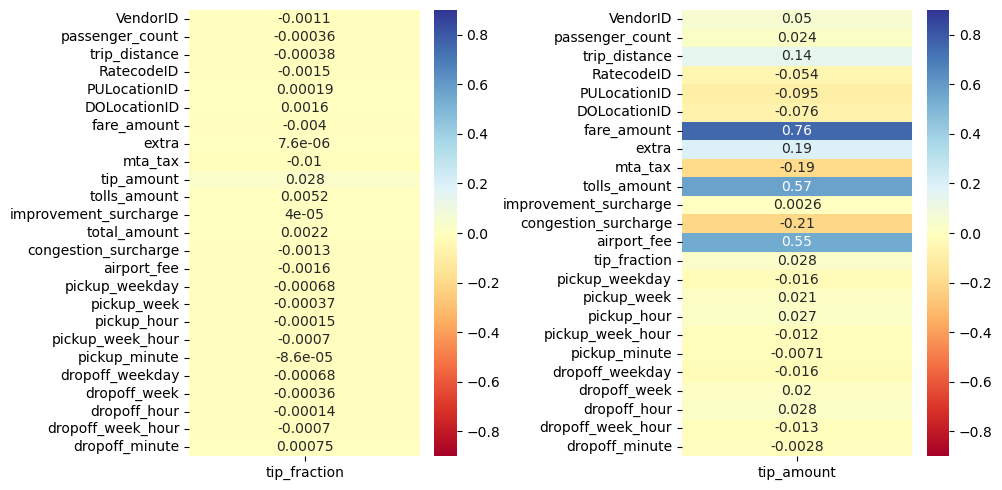

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(
    corr_tip_fraction,
    annot=True,
    cmap="RdYlBu", center=0,
    vmin=-0.9, vmax=0.9,
    ax=axs[0]
)

sns.heatmap(
    corr_tip_amount,
    annot=True,
    cmap="RdYlBu", center=0,
    vmin=-0.9, vmax=0.9,
    ax=axs[1]
)

fig.tight_layout()

These correlation plots suggest that the `tip_fraction` is mostly uncorrelated from all the other parameters. The (absolute) `tip_amount` itself is strongly correlated to the `tolls_amount`, `trip_distance` and `fare_amount`.

## Modeling tip amount

Based on the preceding correlation plots, we prepare the dataset by only selecting the `tolls_amount`, `trip_distance` and `fare_amount` as the exogenous variables in our regression model. We extract this new dataset from the filtered taxi dataset using typical column selection. We then split the DataFrame into a training and a testing set with a ratio of $70%/30%$, respectively–which is standard practice in machine learning. 

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    taxi_filtered[['tolls_amount', 'trip_distance', 'RatecodeID', 'fare_amount']],
    taxi_filtered['tip_amount'],
    test_size=0.3,
    train_size=0.7,
)

Next, we train a model and use the test data to evaluate the [RMSE (Root-Mean-Square-Error)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) and the [$R^2$ statistic](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) (computed with the functions [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) & [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) respectively, both from [Scikit-Learn's `metrics` submodule](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)).

In [12]:
model = LinearRegression()
# model = RandomForestRegressor(max_depth=50)

fitted = model.fit(x_train, y_train)
preds = model.predict(x_test)

print(
    f"RMSE: {mean_squared_error(y_test, preds, squared=False)}\n"
    f"R2: {r2_score(y_test, preds)}\n"
)

preds = pd.Series(preds, index=y_test.index)
preds_data = pd.DataFrame({'Pred': preds, 'Test': y_test})

RMSE: 2.469476286476048
R2: 0.5838287337214791



The RMSE and $R^2$ scores give us a decent first idea of the performance of the model. We can also analyze the density of the output.

In [13]:
sample = preds_data.sample(9999)

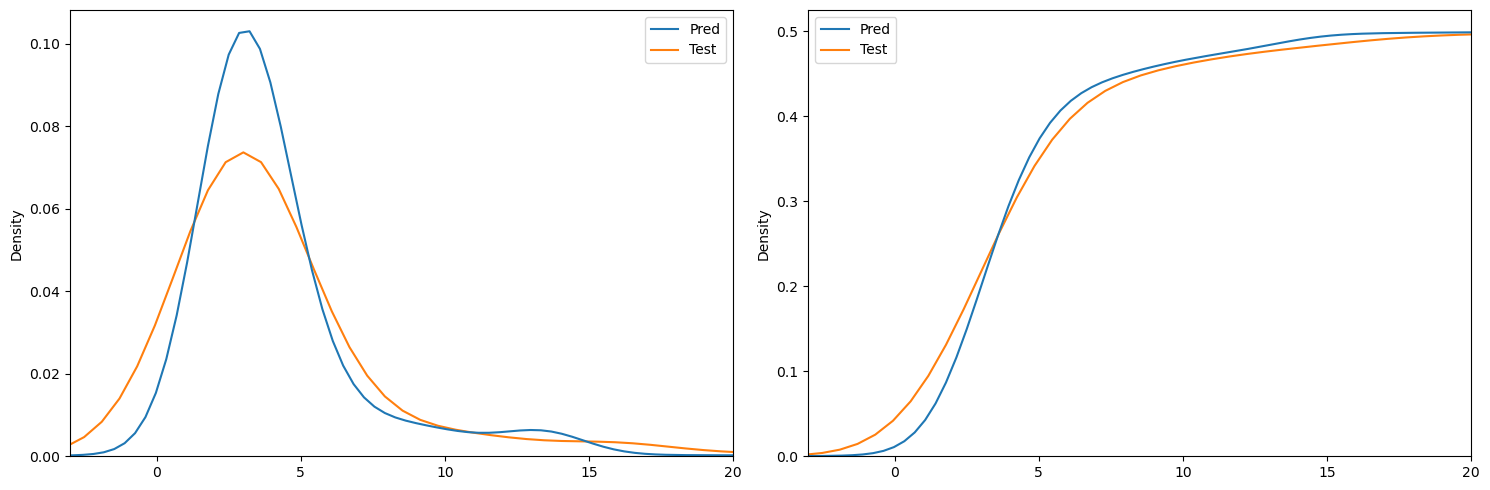

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set(xlim=[-3, 20])
axs[1].set(xlim=[-3, 20])

sns.kdeplot(data=sample, ax=axs[0], bw_adjust=3)
sns.kdeplot(data=sample, ax=axs[1], bw_adjust=3, cumulative=True)

fig.tight_layout()

The model is of modest quality but can be useful to provide first estimate.

## Load more data

Now, let's try to load 4 months instead of 1 to have more data. Loading 4 more files will raise our memory consumption and it will trigger the auto-scaler.

In [ ]:
parquet_files = [
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-03.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-04.parquet",
]

taxi = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in parquet_files
)

Now that we are back, we can see that the state and memory of all previous cells was preserved. And we can see that the last cell we tried to run (loading more data) was not lost too.

In [ ]:
for data_ in data:
    mem_df = taxi.memory_usage(deep=True, index=True).sum() / 1e6
    print(f"DataFrame is of size: {mem_df} MB")